In [1]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'figure.figsize': (12, 6)
})
plt.rc('font', family='arial')

In [2]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-labs/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

In [3]:
GC_WINDOW_SIZE = 1000

## Non-exonic Chen windows, with Gnocchi, and various features (e.g. GC content), and enhancer-overlap status 

In [4]:
import polars as pl

def get_gnocchi_for_unconstrained_windows(): 
    df = pl.read_csv(
        # non-exonic windows
        f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.features.constraint_scores.bed', 
        separator='\t',
    )
    df = df.filter(pl.col('window overlaps enhancer') == False) # putatively unconstrained windows 
    df = df.to_pandas()
    return df 
    
GNOCCHI_FOR_UNCONSTRAINED_WINDOWS = get_gnocchi_for_unconstrained_windows()
GNOCCHI_FOR_UNCONSTRAINED_WINDOWS

,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi,depletion_rank_constraint_score,depletion_rank_constraint_score_complement
0,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657,0.679834,0.320166
1,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925,0.320987,0.679013
2,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243,0.718503,0.281497
3,chr1,1467000,1468000,2.958469,273,False,False,0.651,0.039046,0.025852,...,2.585568,0.636364,0.552345,0.583014,0.574087,NaN,False,326.453703,0.805056,0.194944
4,chr1,1476000,1477000,-0.662737,301,False,False,0.651,0.039046,0.025852,...,2.585568,0.556444,0.595440,0.582994,0.573887,NaN,False,289.719448,0.883274,0.116726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693265,chr9,137136000,137137000,3.277688,258,False,False,0.555,0.150095,0.005393,...,2.281162,0.631369,0.551045,0.588594,0.583316,NaN,False,316.292417,0.558267,0.441733
693266,chr9,137137000,137138000,2.779895,254,False,False,0.555,14.102295,1.698819,...,2.281162,0.586414,0.559444,0.587014,0.583278,NaN,False,302.336307,0.422128,0.577872
693267,chr9,137138000,137139000,3.286597,219,False,False,0.556,0.150095,0.005393,...,2.281162,0.616384,0.584242,0.588514,0.583253,217.0,True,273.337005,0.002164,0.997836
693268,chr9,137146000,137147000,6.685589,237,False,False,0.556,0.004152,0.000249,...,2.281162,0.666334,0.620738,0.600204,0.582346,116.0,True,364.670293,0.545990,0.454010


## Logistic regression: predicting Gnocchi in putatively unconstrained windows as a function of GC_content, gBGC and BGS 

In [25]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression

# Assume GNOCCHI_FOR_UNCONSTRAINED_WINDOWS is a pandas DataFrame
df = GNOCCHI_FOR_UNCONSTRAINED_WINDOWS

# Check if the necessary columns exist in the DataFrame
assert set(['B', 'GC_content_1000bp', 'B_M1star.EUR', 'gnocchi']).issubset(df.columns)

# Define the feature matrix X and the target variable y
X = df[['B', 'GC_content_1000bp', 'B_M1star.EUR']]
y = df['gnocchi']

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

LinearRegression()

In [24]:
# Import necessary library
import statsmodels.api as sm

# Add a constant to the feature matrix X
X = sm.add_constant(X)

# Create a OLS model
model = sm.OLS(y, X)

# Fit the model to the data
results = model.fit()

# Get the coefficients, standard errors, and p-values
coefficients = results.params
standard_errors = results.bse
pvalues = results.pvalues

# Print the coefficients, standard errors, and p-values with 3 significant digits
for feature in X.columns:
    print(f'{feature}:')
    print(f'  Coefficient: {coefficients[feature]:.3g}')
    print(f'  Standard Error: {standard_errors[feature]:.3g}')
    print(f'  P-value: {pvalues[feature]:.3g}')

const:
  Coefficient: -3.33
  Standard Error: 0.021
  P-value: 0
B:
  Coefficient: -0.67
  Standard Error: 0.0193
  P-value: 8.43e-264
GC_content_1000bp:
  Coefficient: 8.74
  Standard Error: 0.039
  P-value: 0
B_M1star.EUR:
  Coefficient: 0.483
  Standard Error: 0.00862
  P-value: 0


<ipython-input-20-38469e46a632>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(limits, limits, 'k-', color = 'r')


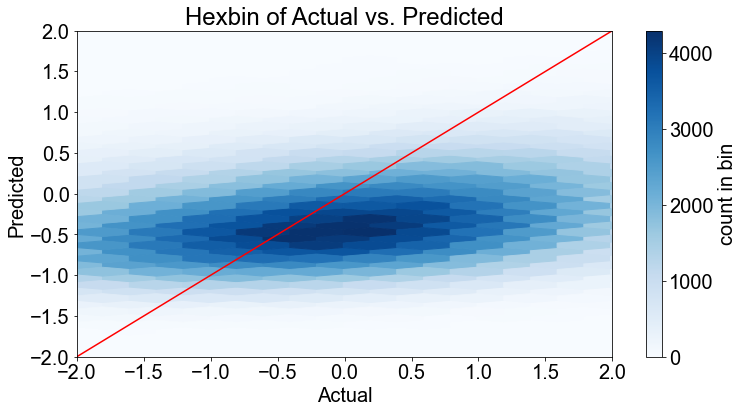

In [20]:
# Import necessary library
import matplotlib.pyplot as plt

# Get the predicted values
y_pred = results.predict(X)

# Create a hexbin plot of actual vs. predicted values
plt.hexbin(y, y_pred, gridsize=50, cmap='Blues')
cb = plt.colorbar(label='count in bin')

# Superimpose a diagonal line
limits = [min(y.min(), y_pred.min()), max(y.max(), y_pred.max())]
plt.plot(limits, limits, 'k-', color = 'r')

# Set x and y limits
plt.xlim([-2, 2])
plt.ylim([-2, 2])

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Hexbin of Actual vs. Predicted')
plt.show()

In [ ]:
# TODO 
# 0. plot predicted gnocchi as a function of GC content, and plot average gnocchi in bins of GC content; repeat for other features 
# 1. use R2 to report the variance of gnocchi that is explained by the features (10%) 
# 2. use partial R2 or ANOVA to report how much of the variance is explained by each featuer (the majority is captured by GC content)

In [ ]:
# TODO: 
# repeat for DR, CDTS and lamba_s